<a href="https://colab.research.google.com/github/yingtongxiong/MLCnotebooks/blob/xytExercise/5_Automatic_program_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     |████████████████████████████████| 45.5 MB 3.1 MB/s 


In [2]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [3]:
import IPython


def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.formatters import HtmlFormatter
    from pygments.lexers import Python3Lexer
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

In [4]:
@tvm.script.ir_module
class MyModule:
  @T.prim_func
  def main(A: T.Buffer[(128, 128), "float32"],
           B: T.Buffer[(128, 128), "float32"],
           C: T.Buffer[(128, 128), "float32"]):
    T.func_attr({"global_symbol":"main", "tir.noalias":True})
    for i, j, k in T.grid(128, 128, 128):
      with T.block("C"):
        vi, vj, vk = T.axis.remap("SSR", [i, j, k])
        with T.init():
          C[vi, vj] = 0.0
        C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vk, vj]
        

In [5]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
c_mm = a_np @ b_np

In [6]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((128, 128), dtype="float32")

lib = tvm.build(MyModule, target="llvm")
f_timer_before = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule: %.3f ms" % (f_timer_before(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule: 3.042 ms


In [10]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

In [11]:
sch = tvm.tir.Schedule(MyModule)
sch = schedule_mm(sch)
IPython.display.HTML(code2html(sch.mod.script()))

In [12]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule=>schedule_mm: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule=>schedule_mm: 2.031 ms


In [13]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
l4, l5 = sch.split(loop=l2, factors=[None, 4], preserve_unit_iters=True)
sch.reorder(l1, l4, l3, l5)
b6 = sch.decompose_reduction(block=b0, loop=l3)


## 随机调度变换

In [14]:
def stochastic_schedule_mm(sch: tvm.tir.Schedule):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_factors = sch.sample_perfect_tile(loop=j, n=2)
    j_0, j_1 = sch.split(loop=j, factors=j_factors)
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

In [17]:
sch = tvm.tir.Schedule(MyModule)
sch = stochastic_schedule_mm(sch)

IPython.display.HTML(code2html(sch.mod.script()))

In [18]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)


In [19]:
sch = tvm.tir.Schedule(MyModule)
block_C = sch.get_block("C", "main")
i, j, k = sch.get_loops(block=block_C)
j_factors = sch.sample_perfect_tile(loop=j, n=2)

In [20]:
type(j_factors[0])

tvm.tir.expr.Var

In [21]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])


In [22]:
IPython.display.HTML(code2html(sch.mod.script()))

In [23]:
j_0, j_1 = sch.split(loop=j, factors=j_factors)
sch.reorder(i, j_0, k, j_1)

In [24]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)


In [25]:
IPython.display.HTML(code2html(sch.mod.script()))

In [26]:
sch.reorder(i, j_0, k, j_1)
sch.decompose_reduction(block_C, k)

tir.BlockRV(0x34cc7b0)

In [27]:
IPython.display.HTML(code2html(sch.mod.script()))

In [28]:
def random_search(mod: tvm.IRModule, num_trials=5):
    best_result = None
    best_sch = None

    for i in range(num_trials):
        sch = stochastic_schedule_mm(tvm.tir.Schedule(mod))
        lib = tvm.build(sch.mod, target="llvm")
        f_timer_after = lib.time_evaluator("main", tvm.cpu())
        result = f_timer_after(a_nd, b_nd, c_nd).mean

        print("=====Attempt %d, time-cost: %.3f ms====" % (i, result * 1000))
        print(sch.trace)

        # book keep the best result so far
        if best_result is None or result < best_result:
            best_result = result
            best_sch = sch

    return best_sch

sch = random_search(MyModule)

=====Attempt 0, time-cost: 2.013 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[32, 4])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 1, time-cost: 2.012 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[32, 4])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 2, time-cost: 3.549 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[64, 2])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_it

In [29]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[32, 4])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)


In [30]:
from tvm import meta_schedule as ms

sch_tuned = ms.tune_tir(
    mod=MyModule,
    target="llvm --num-cores=1",
    config=ms.TuneConfig(
        max_trials_global=64,
        num_trials_per_iter=64,
    ),
    space=ms.space_generator.ScheduleFn(stochastic_schedule_mm),
    work_dir="./tune_tmp",
    task_name="main",
)

2022-10-15 12:32:21.977 INFO Logging directory: ./tune_tmp/logs
2022-10-15 12:32:21.983 INFO Logging directory: ./tune_tmp/logs
2022-10-15 12:32:21.985 INFO Working directory: ./tune_tmp
2022-10-15 12:32:21.988 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-10-15 12:32:21.989 INFO LocalBuilder: max_workers = 1
2022-10-15 12:32:22.728 INFO LocalRunner: max_workers = 1
2022-10-15 12:32:23.444 INFO Initializing Task #0: "main"
2022-10-15 12:32:23.458 INFO 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
------------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |            
------------------------------------------------------------------------------------------------------------
Total trials: 

In [31]:
print(sch_tuned.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)
sch.enter_postproc()


In [32]:
IPython.display.HTML(code2html(sch_tuned.mod.script()))

In [33]:
lib = tvm.build(sch_tuned.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 1.388 ms


In [34]:
sch_tuned = ms.tune_tir(
    mod=MyModule,
    target="llvm --num-cores=1",
    config=ms.TuneConfig(
        max_trials_global=64,
        num_trials_per_iter=64,
    ),
    # space=ms.space_generator.ScheduleFn(stochastic_schedule_mm),
    work_dir="./tune_tmp",
    task_name="main",
)

2022-10-15 12:35:19.449 INFO Logging directory: ./tune_tmp/logs
2022-10-15 12:35:19.455 INFO Logging directory: ./tune_tmp/logs
2022-10-15 12:35:19.458 INFO Working directory: ./tune_tmp
2022-10-15 12:35:19.459 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-10-15 12:35:19.471 INFO LocalBuilder: max_workers = 1
2022-10-15 12:35:20.431 INFO LocalRunner: max_workers = 1
2022-10-15 12:35:21.151 INFO Initializing Task #0: "main"
2022-10-15 12:35:21.167 INFO 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
------------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |            
------------------------------------------------------------------------------------------------------------
Total trials: 

In [35]:
lib = tvm.build(sch_tuned.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.246 ms


In [36]:
sch_tuned.trace

b0 = sch.get_block(name="C", func_name="main")
b1 = sch.get_block(name="root", func_name="main")
sch.annotate(block_or_loop=b0, ann_key="meta_schedule.tiling_structure", ann_val="SSRSRS")
l2, l3, l4 = sch.get_loops(block=b0)
v5, v6, v7, v8 = sch.sample_perfect_tile(loop=l2, n=4, max_innermost_factor=64, decision=[1, 2, 64, 1])
l9, l10, l11, l12 = sch.split(loop=l2, factors=[v5, v6, v7, v8], preserve_unit_iters=True)
v13, v14, v15, v16 = sch.sample_perfect_tile(loop=l3, n=4, max_innermost_factor=64, decision=[1, 4, 1, 32])
l17, l18, l19, l20 = sch.split(loop=l3, factors=[v13, v14, v15, v16], preserve_unit_iters=True)
v21, v22 = sch.sample_perfect_tile(loop=l4, n=2, max_innermost_factor=64, decision=[16, 8])
l23, l24 = sch.split(loop=l4, factors=[v21, v22], preserve_unit_iters=True)
sch.reorder(l9, l17, l10, l18, l23, l11, l19, l24, l12, l20)
sch.annotate(block_or_loop=b1, ann_key="meta_schedule.parallel", ann_val=16)
sch.annotate(block_or_loop=b1, ann_key="meta_schedule.vectorize", ann_

In [37]:
IPython.display.HTML(code2html(sch_tuned.mod.script()))

## 回到端到端模型执行

In [38]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



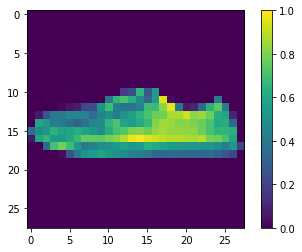

Class: Sneaker


In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [40]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-10-15 12:39:45--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-10-15 12:39:45--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.03s   

2022-10-15 12:39:46 (15.3 MB/s) - ‘fasionmnist_mlp_para

In [41]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [42]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

In [43]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

In [44]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

In [45]:
ex = relax.vm.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Sneaker


In [46]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=100)

print("MyModuleWithParams time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams time-cost: 0.459154 ms


In [47]:
mod_linear = tvm.IRModule.from_expr(MyModuleMixture["linear0"].with_attr("global_symbol", "main"))
IPython.display.HTML(code2html(mod_linear.script()))

In [48]:
sch_tuned_linear = ms.tune_tir(
    mod=mod_linear,
    target="llvm --num-cores=1",
    config=ms.TuneConfig(
      max_trials_global=64,
      num_trials_per_iter=64,
    ),
    work_dir="./tune_tmp",
    task_name="main",
)

2022-10-15 12:43:27.644 INFO Logging directory: ./tune_tmp/logs
2022-10-15 12:43:27.651 INFO Logging directory: ./tune_tmp/logs
2022-10-15 12:43:27.655 INFO Working directory: ./tune_tmp
2022-10-15 12:43:27.659 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-10-15 12:43:27.780 INFO LocalBuilder: max_workers = 1
2022-10-15 12:43:28.863 INFO LocalRunner: max_workers = 1
2022-10-15 12:43:29.559 INFO Initializing Task #0: "main"
2022-10-15 12:43:29.580 INFO 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
-----------------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |            N/A |          N/A |                   N/A |      0 |            
-----------------------------------------------------------------------------------------------------------
Total trials: 0
To

In [49]:
MyModuleWithParams2 = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
new_func = sch_tuned_linear.mod["main"].with_attr("global_symbol", "linear0")
gv = MyModuleWithParams2.get_global_var("linear0")
MyModuleWithParams2.update_func(gv, new_func)
IPython.display.HTML(code2html(MyModuleWithParams2.script()))

In [50]:
ex = relax.vm.build(MyModuleWithParams2, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams2 Prediction:", class_names[pred_kind[0]])

MyModuleWithParams2 Prediction: Sneaker


In [51]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=50)

print("MyModuleWithParams2 time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams2 time-cost: 0.202655 ms
